In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

### Lab Measures

In [58]:
# Metrix
C_metrix = 671e-12
R_metrix = 26.95
RL_metrix = 9.96

#From previous measurements
Rg = 48.8
L = 350.0e-6

Rtot = R_metrix + Rg + RL_metrix
print("Rtot = ", Rtot)

Rtot =  85.71000000000001


### Expected Results

In [59]:
Q = 1.0/Rtot*np.sqrt(L/C_metrix)
print("Q = ", Q)
f0 = 1/(2*np.pi)*np.sqrt(1/(L*C_metrix))
print("f0 = ", f0*1e-3, "kHz")

Q =  8.426384396740353
f0 =  328.4164099829851 kHz


### Input Processing

In [60]:
project_name = "RLC_freq"

data = np.genfromtxt(f'../input/{project_name}.csv', delimiter=';', skip_header=1)
f_data, Vin_data, Vout_data , Vin_div, Vout_div, t_data, t_div= data.T
Tr_data = Vout_data/Vin_data



### Errors

In [61]:
err_readingV = 0.1*0.41
err_scaleV = 0.03*0.41
Vout_err = err_readingV*Vout_div
Vin_err = err_readingV*Vin_div

Tr_err = Tr_data * np.sqrt((Vout_err/Vout_data)**2 + (Vin_err/Vin_data)**2+2*(err_scaleV)**2)


### Plot Params

In [62]:
plt.style.use('seaborn-v0_8-whitegrid') 
params = {
    'figure.figsize': (8, 6),
    'axes.labelsize': 12,
    'figure.titlesize': 16,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'legend.fontsize': 11,
    'legend.framealpha': 0.8,
    'legend.loc': 'best',
    'figure.dpi': 120,
    'savefig.dpi': 150,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.constrained_layout.use': True,
    'text.usetex': True, 
}
plt.rcParams.update(params)

### Plot Raw


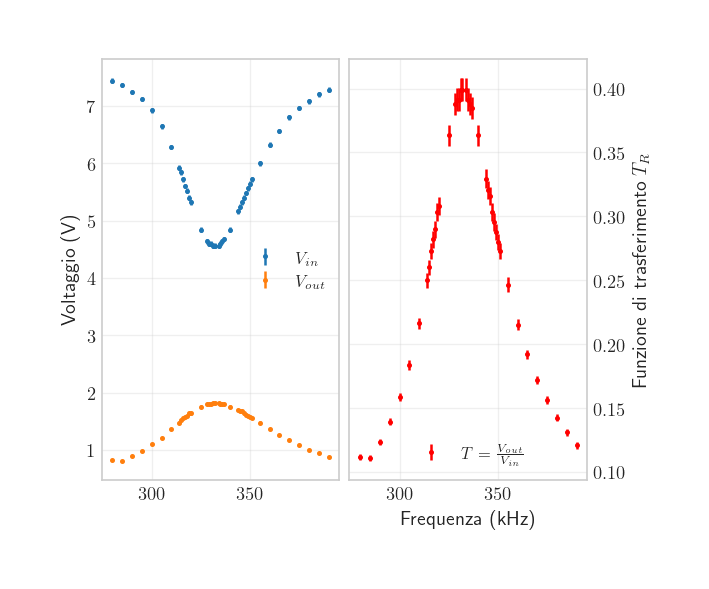

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4), sharex=True, constrained_layout=True, width_ratios=[1, 1])
ax[0].errorbar(f_data, Vin_data, yerr=Vin_err, fmt='o', label=r'$V_{in}$', ms=2)
ax[0].errorbar(f_data, Vout_data, yerr=Vout_err, fmt='o', label=r'$V_{out}$', ms=2)
ax[0].legend(prop={'size': 10}, loc='best')
ax[0].set_ylabel(r'Voltaggio (V)')

ax[1].errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label=r'$T=\frac{V_{out}}{V_{in}}$', ms=2, color='red')
ax[1].legend(prop={'size': 10}, loc='best')
ax[1].set_ylabel(r'Funzione di trasferimento $T_R$')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position('right')

plt.savefig(f'../output/{project_name}_rawdata.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

### Fit Function

In [64]:
def fitf(x, A, B, C):
    # Amplitude, B: resonant frequency, C: quality factor
    omega = 2.0 * np.pi * x * 1e3  # input in kHz
    fitval = A / np.sqrt(1+C**2*(omega/B-B/omega)**2)
    return fitval



### Initial estimate

In [65]:
Ainit= 0.4
Binit =  2.0 * np.pi *f0  # Hz
Cinit = Q

### First fit

In [66]:
popt, pcov = curve_fit(fitf, f_data, Tr_data, p0=[Ainit, Binit, Cinit], method='lm', sigma=Tr_err, absolute_sigma=True)
print("popt = ", popt)
print(popt[1]/(2*np.pi), "Hz")

popt =  [3.99371308e-01 2.09584472e+06 1.03484352e+01]
333564.0469653246 Hz


In [67]:
perr = np.sqrt(np.diag(pcov))
f0_fit = popt[1] / (2 * np.pi)  # Convert omega to frequency
f0_fit_err = perr[1] / (2 * np.pi)  # Convert omega error to frequency error

print('A = {a:.3f} +/- {b:.3f} \n f0 = {c:.3f} +/- {d:.3f} kHz \n Q = {e:.1f} +/- {f:.1f}'.format(
    a=popt[0], b=perr[0], c=f0_fit / 1000, d=f0_fit_err / 1000, e=popt[2], f=perr[2]))

residuals = Tr_data - fitf(f_data, *popt)
chisq = np.sum((residuals / Tr_err)**2)
df = len(f_data) - 3
chisq_red = chisq / df
print("chisq = ", chisq)
print("chisq_red = ", chisq_red)

A = 0.399 +/- 0.003 
 f0 = 333.564 +/- 0.141 kHz 
 Q = 10.3 +/- 0.1
chisq =  59.90795876262186
chisq_red =  1.5765252305953121


### Fit plot

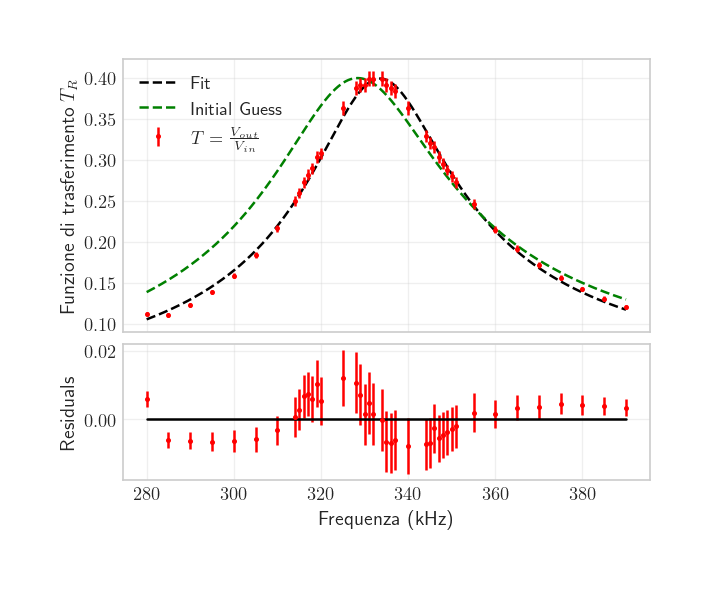

In [68]:
x_fit = np.linspace(min(f_data), max(f_data), 1000)

# Plot the fit
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True, constrained_layout=True, height_ratios=[2, 1])
ax[0].plot(x_fit, fitf(x_fit, *popt), label='Fit', linestyle='--', color='black')
ax[0].plot(x_fit, fitf(x_fit, Ainit, Binit, Cinit), label='Initial Guess', linestyle='dashed', color='green')
ax[0].errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label=r'$T=\frac{V_{out}}{V_{in}}$', ms=2, color='red')
ax[0].legend(loc='upper left')
ax[0].set_ylabel(r'Funzione di trasferimento $T_R$')

ax[1].errorbar(f_data, residuals, yerr=Tr_err, fmt='o', label='Residuals', ms=2, color='red')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].plot(f_data, np.zeros(len(f_data)), color='black')

plt.savefig(f'../output/{project_name}_fit.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)
